In [4]:
# pip install lightgbm

In [288]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### 1. 데이터 선별

In [234]:
train = pd.read_csv('sample_data/train.csv')

print('제한 전 train 데이터 크기:', train.shape) # 행, 열 갯수 출력
train

제한 전 train 데이터 크기: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [235]:
"""
iloc[행, 열] => 판다스에서 제공하는 인덱싱 함수, 특정 행과 열을 인덱스를 통해 선택
train.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1]]
':' => 모든 행 선택
'[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1]]'
    └> 0~9: 첫번째부터 열번쨰 열을 선택, -1은 마지막 열을 선택
    └> 
"""

train = train.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1]]
print('제한 후 train 데이터 크기:', train.shape)
train

제한 후 train 데이터 크기: (1460, 11)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,142125


### 2. 결측치 제거

In [236]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           1460 non-null   int64  
 1   MSSubClass   1460 non-null   int64  
 2   MSZoning     1460 non-null   object 
 3   LotFrontage  1201 non-null   float64
 4   LotArea      1460 non-null   int64  
 5   Street       1460 non-null   object 
 6   Alley        91 non-null     object 
 7   LotShape     1460 non-null   object 
 8   LandContour  1460 non-null   object 
 9   Utilities    1460 non-null   object 
 10  SalePrice    1460 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 125.6+ KB


In [237]:
test = pd.DataFrame({
    "A": [1, 2, None],
    "B": [4, None, None],
    "C": [7, 8, 9]
})
print(test.isnull()) # DataFrame의 각 값이 None인지 아닌지를 확인
print("-" * 50)
print("━━━━━.T로 행-열 전치━━━━━")
print(test.isnull().T) # isnull() 결과를 전치
print("-" * 50)
print(test.isnull().sum()) # True를 1로, False를 0으로 간주하여 열(column)별로 합계를 구함
print("-" * 50)
print(test.isnull().sum()[test.isnull().sum() > 0]) # 각 열의 결측값 개수(train.isnull().sum())가 0보다 큰 열만 필터링합니다.

       A      B      C
0  False  False  False
1  False   True  False
2   True   True  False
--------------------------------------------------
━━━━━.T로 행-열 전치━━━━━
       0      1      2
A  False  False   True
B  False   True   True
C  False  False  False
--------------------------------------------------
A    1
B    2
C    0
dtype: int64
--------------------------------------------------
A    1
B    2
dtype: int64


In [238]:
# 결측치 확인
train.isnull().sum()[train.isnull().sum() > 0]

LotFrontage     259
Alley          1369
dtype: int64

In [239]:
train.isnull().T

,0,1,2,3,4,5,6,7,8,9,...,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
Id,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MSSubClass,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MSZoning,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LotFrontage,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
LotArea,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Street,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Alley,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,True
LotShape,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LandContour,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Utilities,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [240]:
print(train.isnull().sum())
print("-" *50)
print(train.isnull().sum()[train.isnull().sum() > 0])
print("-" *50)
print(train.info())

Id                0
MSSubClass        0
MSZoning          0
LotFrontage     259
LotArea           0
Street            0
Alley          1369
LotShape          0
LandContour       0
Utilities         0
SalePrice         0
dtype: int64
--------------------------------------------------
LotFrontage     259
Alley          1369
dtype: int64
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           1460 non-null   int64  
 1   MSSubClass   1460 non-null   int64  
 2   MSZoning     1460 non-null   object 
 3   LotFrontage  1201 non-null   float64
 4   LotArea      1460 non-null   int64  
 5   Street       1460 non-null   object 
 6   Alley        91 non-null     object 
 7   LotShape     1460 non-null   object 
 8   LandContour  1460 non-null   object 
 9   Utilities    1460 non-null   object 
 

### 3. 결측치를 어떻게 할것인지 결정
- 결측치 비율을 보고 Task, Business, Domain 지식 등 다양한 부분에 따라 결정
- 이러한 지식이 없다면 반복 실 후 결과를 확인 후 결정정

In [241]:
"""
[dropna() 함수]
pandas에서 결측값(NaN)이 있는 데이터(행 또는 열)를 제거하는 함수

[axis 매개변수]
axis=0 (기본값): 행(row)을 기준으로 결측값이 있는 행을 제거
axis=1: 열(column)을 기준으로 결측값이 있는 열을 제거
"""

# 결측치가 있는 컬럼 제거
# train_dropna = train.dropna(axis=1)
# print('\033[1mtrain 데이터 크기 : \033[0m', train_dropna.shape)
# print("-" *50)
# train_dropna

train_dropna = train.dropna(axis=1)
print('결측치 제거 후 데이터: ', train_dropna.shape)
train_dropna

결측치 제거 후 데이터:  (1460, 9)


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,250000
...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,142125


### 4. 자료분석

In [242]:
train_dropna['Id'].value_counts() # id => 수치형

Id
1       1
982     1
980     1
979     1
978     1
       ..
485     1
484     1
483     1
482     1
1460    1
Name: count, Length: 1460, dtype: int64

In [243]:
train_dropna['MSSubClass'].value_counts() # 건물유형 => 수치형

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64

In [244]:
train_dropna['MSZoning'].value_counts() # 일반적인 구역 분류 => 범주형

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [245]:
train_dropna['LotArea'].value_counts() #대지면적 => 수치형 

LotArea
7200     25
9600     24
6000     17
9000     14
8400     14
         ..
14601     1
13682     1
4058      1
17104     1
9717      1
Name: count, Length: 1073, dtype: int64

In [246]:
train_dropna['Street'].value_counts() # 도로 접근 유형 => 범주형

Street
Pave    1454
Grvl       6
Name: count, dtype: int64

In [247]:
train_dropna['LotShape'].value_counts() #대지의 형태 =>범주형

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

In [248]:
train_dropna['LandContour'].value_counts() # 대지의 평탄도  =>범주형

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

In [249]:
train_dropna['Utilities'].value_counts() # 사용가능한 유틸리티 시설  =>범주형

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

<Axes: >

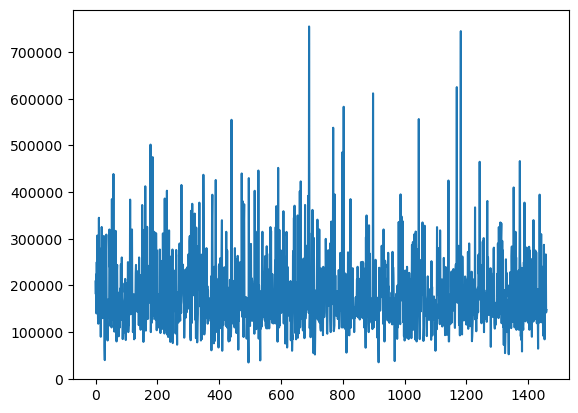

In [250]:
# 주택가격(SalePrice) 시각화
# y축: SalePrice, x축: train_dropna DataFrame의 각 행에 대한 고유 번호(0부터 시작)
train_dropna['SalePrice'].plot() 

### 5. EDA 결과 반영
- 데이터를 탐색하고 분석하여 얻은 정보를 바탕으로 데이터에 필요한 조치를 취하거나 모델링에 적용하는 것

In [251]:
# 범주형 데이터(카테고리의 범주가 있는 텍스트 데이터)를 수치형 데이터로 변경
# 뒤에서 사용할 LGBMRegressor는 수치형 데이터만 처리가능
"""
예시) MSZoning의 범주

RL         1151
RM          218
FV           65
RH           16
C (all)

"""

# MSZoning 컬럼 수치형으로 변경
le = LabelEncoder()
le.fit(train_dropna['MSZoning'])
train_dropna['MSZoning'] = le.transform(train_dropna['MSZoning'])

# Street 컬럼 수치형으로 변경
le = LabelEncoder()
le.fit(train_dropna['Street'])
train_dropna['Street'] = le.transform(train_dropna['Street'])

# LotShape 컬럼 수치형으로 변경
le = LabelEncoder()
le.fit(train_dropna['LotShape'])
train_dropna['LotShape'] = le.transform(train_dropna['LotShape'])

# LandContour 컬럼 수치형으로 변경
le = LabelEncoder()
le.fit(train_dropna['LandContour'])
train_dropna['LandContour'] = le.transform(train_dropna['LandContour'])

# LandContour 컬럼 수치형으로 변경
le = LabelEncoder()
le.fit(train_dropna['Utilities'])
train_dropna['Utilities'] = le.transform(train_dropna['Utilities'])

C:\Users\EZENIC-031\AppData\Local\Temp\ipykernel_5488\10701135.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dropna['MSZoning'] = le.transform(train_dropna['MSZoning'])
C:\Users\EZENIC-031\AppData\Local\Temp\ipykernel_5488\10701135.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dropna['Street'] = le.transform(train_dropna['Street'])
C:\Users\EZENIC-031\AppData\Local\Temp\ipykernel_5488\10701135.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [252]:
train_dropna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Id           1460 non-null   int64
 1   MSSubClass   1460 non-null   int64
 2   MSZoning     1460 non-null   int32
 3   LotArea      1460 non-null   int64
 4   Street       1460 non-null   int32
 5   LotShape     1460 non-null   int32
 6   LandContour  1460 non-null   int32
 7   Utilities    1460 non-null   int32
 8   SalePrice    1460 non-null   int64
dtypes: int32(5), int64(4)
memory usage: 74.3 KB


In [253]:
train_dropna

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,SalePrice
0,1,60,3,8450,1,3,3,0,208500
1,2,20,3,9600,1,3,3,0,181500
2,3,60,3,11250,1,0,3,0,223500
3,4,70,3,9550,1,0,3,0,140000
4,5,60,3,14260,1,0,3,0,250000
...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,7917,1,3,3,0,175000
1456,1457,20,3,13175,1,3,3,0,210000
1457,1458,70,3,9042,1,3,3,0,266500
1458,1459,20,3,9717,1,3,3,0,142125


In [254]:
"""
-count: 해당 열에서 결측치(NaN)를 제외한 값의 개수
-mean: 열의 평균값입니다.
-std (standard deviation): 열의 표준편차로, 데이터의 산포(흩어진 정도). 값이 클수록 데이터가 평균값에서 더 많이 분포되어 있음
-min: 열에서 가장 작은 값
-25% (1st quartile): 데이터의 25번째 백분위수 값으로, 데이터의 하위 25%가 이 값 이하에 위치
-50% (median): 데이터의 중앙값입니다.데이터가 정규분포를 따른다면 평균값(mean)과 유사합니다.
-75% (3rd quartile): 데이터의 75번째 백분위수 값으로, 데이터의 상위 25%가 이 값 이상에 위치
-max:열에서 가장 큰 값입니다.
"""
# 기초 통계량 확인
train_dropna.describe()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,3.028767,10516.828082,0.995890,1.942466,2.777397,0.000685,180921.195890
std,421.610009,42.300571,0.632017,9981.264932,0.063996,1.409156,0.707666,0.026171,79442.502883
min,1.000000,20.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,365.750000,20.000000,3.000000,7553.500000,1.000000,0.000000,3.000000,0.000000,129975.000000
50%,730.500000,50.000000,3.000000,9478.500000,1.000000,3.000000,3.000000,0.000000,163000.000000
75%,1095.250000,70.000000,3.000000,11601.500000,1.000000,3.000000,3.000000,0.000000,214000.000000
max,1460.000000,190.000000,4.000000,215245.000000,1.000000,3.000000,3.000000,1.000000,755000.000000


In [255]:
train_dropna.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
MSZoning,1460.0,3.028767,0.632017,0.0,3.00,3.0,3.00,4.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
Street,1460.0,0.995890,0.063996,0.0,1.00,1.0,1.00,1.0
LotShape,1460.0,1.942466,1.409156,0.0,0.00,3.0,3.00,3.0
LandContour,1460.0,2.777397,0.707666,0.0,3.00,3.0,3.00,3.0
Utilities,1460.0,0.000685,0.026171,0.0,0.00,0.0,0.00,1.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.00,163000.0,214000.00,755000.0


### 6. 학습 데이터, 검증 데이터 분리
- 학습데이터
    - 모델을 학습시키는 데 사용되는 데이터. 입력 데이터(features)와 정답(label 또는 target)으로 구성
- 검증데이터
    - 학습된 모델의 성능을 평가하기 위해 사용되는 데이터

In [256]:
#학습 데이터와 검증 데이터를 분리하는 건수는 정해져 있지 않습니다. 다양한 크기로 분리하여 학습과 검증해 보시기 바랍니다.

# 총 1460건의 데이터를 1400 : 60 으로 분리하여 1400건으로 학습하고, 60건으로 검증
train_data = train_dropna[:1400] # 학습데이터
valid_data = train_dropna[1400:] # 검증데이터

train_data.shape, valid_data.shape

((1400, 9), (60, 9))

In [257]:
# 학습용 데이터 준비
x_train = train_data.iloc[:, :8]
y_train = train_data.iloc[:, 8]

x_train.shape, y_train.shape

((1400, 8), (1400,))

In [259]:
x_train

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities
0,1,60,3,8450,1,3,3,0
1,2,20,3,9600,1,3,3,0
2,3,60,3,11250,1,0,3,0
3,4,70,3,9550,1,0,3,0
4,5,60,3,14260,1,0,3,0
...,...,...,...,...,...,...,...,...
1395,1396,60,3,12665,1,0,3,0
1396,1397,20,3,57200,1,0,0,0
1397,1398,70,4,6120,1,3,3,0
1398,1399,50,3,7200,1,3,3,0


In [260]:
y_train

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1395    281213
1396    160000
1397    137500
1398    138000
1399    137450
Name: SalePrice, Length: 1400, dtype: int64

In [261]:
# 검증용 데이터 준비
x_valid = valid_data.iloc[:, :8]
y_valid = valid_data.iloc[:, 8]

x_valid.shape, y_valid.shape

((60, 8), (60,))

### 7. 모델 학습

In [263]:
#학습 파라메터는 정해져 있지 않습니다. 다양한 크기로 변경하여 학습한 후 검증결과를 확인해 보세요.

# 학습
params = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'num_leaves': 30,
    'objective': 'rmse',
    'random_state': 42,
}

model = lgb.LGBMRegressor(**params) #모델생성

"""
-fit(x_train, y_train):학습 데이터(x_train, y_train)를 사용해 모델을 학습시킵니다.
-eval_set=[(x_valid, y_valid)]: 검증 데이터를 학습 중 평가용으로 설정합니다.
 모델은 학습 중 각 단계에서 검증 데이터의 성능(예: RMSE)을 확인하여 과대적합 여부를 파악합니다.
"""
model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)]) #모델 학습

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 6
[LightGBM] [Info] Start training from score 181085.180714


LGBMRegressor(learning_rate=0.01, n_estimators=500, num_leaves=30,
              objective='rmse', random_state=42)

### 8. 모델예측

In [264]:
# 검증용 데이터를 가지고 예측값(pred) 출력
valid_data['pred'] = model.predict(x_valid)
valid_data

C:\Users\EZENIC-031\AppData\Local\Temp\ipykernel_5488\1242515121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['pred'] = model.predict(x_valid)


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,SalePrice,pred
1400,1401,50,4,6000,1,3,3,0,120000,127810.321198
1401,1402,60,3,7415,1,0,3,0,193000,186090.985533
1402,1403,20,3,6762,1,3,3,0,193879,142462.293149
1403,1404,20,3,15256,1,0,3,0,282922,328326.270595
1404,1405,50,3,10410,1,3,3,0,105000,184737.651850
1405,1406,120,4,3842,1,0,1,0,275000,183654.469144
1406,1407,85,3,8445,1,3,3,0,133000,149054.425016
1407,1408,20,3,8780,1,0,3,0,112000,163527.914734
1408,1409,70,4,7740,1,3,3,0,125500,139884.786687
1409,1410,60,3,20544,1,0,3,0,215000,333041.352759


### 9. 모델검증

In [283]:
#검증
score = mean_squared_error(valid_data['SalePrice'], valid_data['pred']) ** (1/2)
print('RMSE = ', score, '달러')

RMSE =  58791.69911598906 달러


In [282]:
# # 검증 데이터
# # valid_data['SalePrice']: 실제값
# # valid_data['pred']: 예측값

# # RMSE 계산
# score = mean_squared_error(valid_data['SalePrice'], valid_data['pred']) ** (1/2)
# print('RMSE = ', score, '달러')

# # 잔차 계산
# residuals = valid_data['SalePrice'] - valid_data['pred']

# # 그래프 그리기
# plt.figure(figsize=(12, 6))

# # 1. 잔차의 분포 그래프 (히스토그램 + 커널 밀도)
# plt.subplot(1, 2, 1)
# sns.histplot(residuals, kde=True, bins=30, color='blue')
# plt.axvline(x=0, color='red', linestyle='--', label='잔차=0')  # 잔차 0 기준선
# plt.title('잔차 분포')
# plt.xlabel('잔차 (Residuals)')
# plt.ylabel('빈도 (Frequency)')
# plt.legend()

# # 2. 예측값 vs 실제값의 비교
# plt.subplot(1, 2, 2)
# plt.scatter(valid_data['SalePrice'], valid_data['pred'], alpha=0.6, color='orange')
# plt.plot([valid_data['SalePrice'].min(), valid_data['SalePrice'].max()],
#          [valid_data['SalePrice'].min(), valid_data['SalePrice'].max()],
#          color='red', linestyle='--', label='완벽한 예측선 (y=x)')
# plt.title('실제값 vs 예측값')
# plt.xlabel('실제값 (SalePrice)')
# plt.ylabel('예측값 (Predicted)')
# plt.legend()

# # 그래프 출력
# plt.tight_layout()
# plt.show()

### 10.변수 중요도

In [287]:
# 변수 중요도
# 모델이 특정 특성을 얼마나 많이 사용했는지를 나타내는 값
"""
model.feature_name_: LightGBM 모델이 학습에 사용한 특성(feature)의 이름 목록을 반환
index=model.feature_name_: 각 특성의 이름을 인덱스로 설정
columns=['imp']: 특성 중요도를 담은 열(column)의 이름을 'imp'로 설정
"""
val_imp = pd.DataFrame(model.feature_importances_, index=model.feature_name_, columns=['imp'])
val_imp

,imp
Id,4426
MSSubClass,2761
MSZoning,474
LotArea,5681
Street,0
LotShape,747
LandContour,411
Utilities,0


<Axes: >

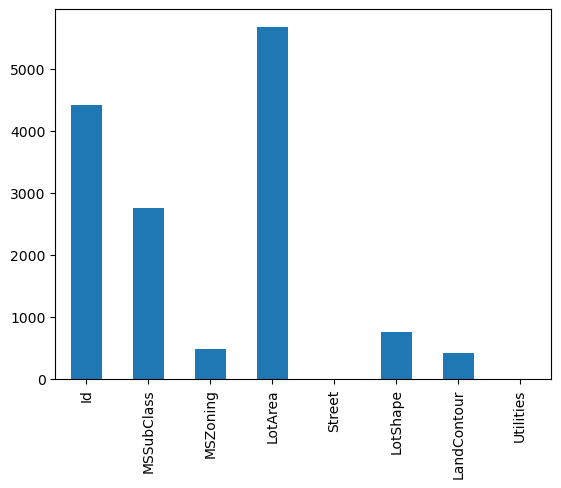

In [281]:
# 변수 중요도 크기에 따라 정렬한 후 시각화
val_imp['imp'].plot(kind='bar')
# 대지면적 > 건물유형 > 대지형태...

### 11. pickle을 사용해 모델의 저장과 불러오기

In [289]:
# 저장 객체 정의
save_object = [model, params, valid_data]

In [290]:
# 저장
with open(file='house_price_model.pickle', mode='wb') as f:
    pickle.dump(save_object, f)

In [291]:
# 저장된 객체 불러오기
with open(file='house_price_model.pickle', mode='rb') as f:
    load_object = pickle.load(f)

In [292]:
# 저장된 객체 분리
model = load_object[0] # 학습된 모델
params = load_object[1] # 파라미터
valid_data = load_object[2] # 검증용데이터

In [293]:
# 예측
valid_data['pred'] = model.predict(x_valid)
valid_data

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,SalePrice,pred
1400,1401,50,4,6000,1,3,3,0,120000,127810.321198
1401,1402,60,3,7415,1,0,3,0,193000,186090.985533
1402,1403,20,3,6762,1,3,3,0,193879,142462.293149
1403,1404,20,3,15256,1,0,3,0,282922,328326.270595
1404,1405,50,3,10410,1,3,3,0,105000,184737.651850
1405,1406,120,4,3842,1,0,1,0,275000,183654.469144
1406,1407,85,3,8445,1,3,3,0,133000,149054.425016
1407,1408,20,3,8780,1,0,3,0,112000,163527.914734
1408,1409,70,4,7740,1,3,3,0,125500,139884.786687
1409,1410,60,3,20544,1,0,3,0,215000,333041.352759
